## Soft Actor-Critic: SAC with 1 Net in Cartpole

In [1]:
import gym

# 定义环境
class MyWrapper(gym.Wrapper):
  def __init__(self):
    env = gym.make('CartPole-v1', render_mode='rgb_array')
    super().__init__(env)
    self.env = env
    self.step_n = 0
  
  def reset(self):
    state, _ = self.env.reset()
    self.step_n = 0
    return state
    
  def step(self, action):
    state, reward, terminated, truncated, info = self.env.step(action)
    done = terminated or truncated
    self.step_n += 1
    if self.step_n >= 200:
      done = True
    return state, reward, done, info 
  
env = MyWrapper()
env.reset()

array([-0.04482345, -0.02106024, -0.00408525, -0.01498255], dtype=float32)

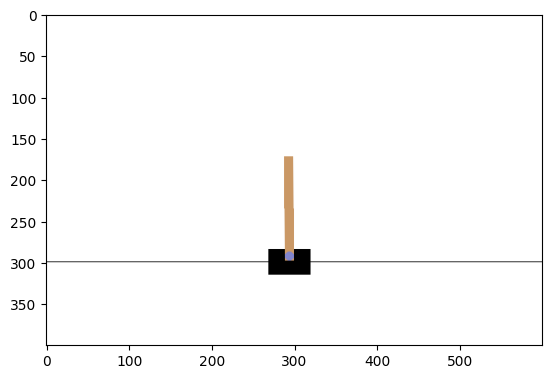

In [2]:
from matplotlib import pyplot as plt

%matplotlib inline

# 打印游戏
def show():
  plt.imshow(env.render())
  plt.show()
  
show()

In [3]:
import torch

# 定义模型
model_action = torch.nn.Sequential(
	torch.nn.Linear(4, 128),
	torch.nn.ReLU(),
  torch.nn.Linear(128, 2),
  torch.nn.Softmax(dim=1),
)

model_action(torch.randn(2, 4))

tensor([[0.5630, 0.4370],
        [0.3885, 0.6115]], grad_fn=<SoftmaxBackward0>)

In [4]:
model_value = torch.nn.Sequential(
	torch.nn.Linear(4, 128),
	torch.nn.ReLU(),
	torch.nn.Linear(128, 2),
)


model_value_next = torch.nn.Sequential(
	torch.nn.Linear(4, 128),
	torch.nn.ReLU(),
	torch.nn.Linear(128, 2),
)

model_value_next.load_state_dict(model_value.state_dict())

model_value(torch.randn(2, 4))

tensor([[-0.4456, -0.0895],
        [ 0.0692, -0.1535]], grad_fn=<AddmmBackward0>)

In [5]:
import random

# 得到一个动作
def get_action(state):
  # 走神经网络，得到一个动作
  state = torch.FloatTensor(state).reshape(1, 4)
  prob = model_action(state)
  
  # 根据概率选择一个动作
  action = random.choices(range(2), weights=prob[0].tolist(), k=1)[0]
  
  return action

get_action([1, 2, 3, 4])

0

In [6]:
# 样本池
datas = []

#向样本池中添加N条数据,删除M条最古老的数据
def update_data():
	old_count = len(datas)

	# 玩到新增N条数据为止
	while len(datas) - old_count < 200:
    # 初始化游戏
		state = env.reset()
  
		# 玩到结束
		over = False
		while not over:
			action = get_action(state)
			
			next_state, reward, over, _ = env.step(action)
			
			datas.append((state, action, reward, next_state, over))
			
			state = next_state
		
	update_count = len(datas) - old_count
	drop_count = max(len(datas) - 10000, 0)

	# 数据上限,超出时从最古老的开始删除
	while len(datas) > 10000:
		datas.pop(0)
    
	return update_count, drop_count

update_data(), len(datas)

((215, 0), 215)

In [7]:
# 获取一批数据样本
def get_sample():
  # 从样本池中采样
  samples = random.sample(datas, 64)
  
  # [b, 3]
  state = torch.FloatTensor([i[0] for i in samples]).reshape(-1, 4)
  # [b, 1]
  action = torch.LongTensor([i[1] for i in samples]).reshape(-1, 1)
  # [b, 1]
  reward = torch.FloatTensor([i[2] for i in samples]).reshape(-1, 1)
  # [b, 3]
  next_state = torch.FloatTensor([i[3] for i in samples]).reshape(-1, 4)
  # [b, 1]
  over = torch.LongTensor([i[4] for i in samples]).reshape(-1, 1)
  
  return state, action, reward, next_state, over

state, action, reward, next_state, over = get_sample()

state[:5], action[:5], reward[:5], next_state[:5], over[:5]

C:\Users\fanyu\AppData\Local\Temp\ipykernel_3656\956863396.py:7: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\torch\csrc\utils\tensor_new.cpp:204.)
  state = torch.FloatTensor([i[0] for i in samples]).reshape(-1, 4)


(tensor([[ 0.0125,  0.2256,  0.0447, -0.2115],
         [ 0.0150,  0.9271,  0.1396, -0.4426],
         [ 0.0175, -0.8054,  0.0332,  1.2741],
         [ 0.0166, -0.4140,  0.0231,  0.6732],
         [-0.0015,  0.0168, -0.0013, -0.0496]]),
 tensor([[1],
         [0],
         [0],
         [0],
         [1]]),
 tensor([[1.],
         [1.],
         [1.],
         [1.],
         [1.]]),
 tensor([[ 1.7023e-02,  4.2007e-01,  4.0477e-02, -4.8974e-01],
         [ 3.3515e-02,  7.3027e-01,  1.3071e-01, -1.0933e-01],
         [ 1.3800e-03, -1.0009e+00,  5.8704e-02,  1.5770e+00],
         [ 8.3231e-03, -6.0939e-01,  3.6575e-02,  9.7303e-01],
         [-1.1373e-03,  2.1189e-01, -2.2850e-03, -3.4268e-01]]),
 tensor([[0],
         [0],
         [0],
         [0],
         [0]]))

In [8]:
from IPython import display

def test(play):
  #初始化游戏
  state = env.reset()
  
  #记录反馈值的和,这个值越大越好
  reward_sum = 0
  
  #玩到游戏结束为止
  over = False
  while not over:
    #根据当前状态得到一个动作
    action = get_action(state)
    
    #执行动作,得到反馈
    state, reward, over, _ = env.step(action)
    reward_sum += reward
    
    # 打印动画
    if play and random.random() < 0.2: # 跳帧
      display.clear_output(wait=True)
      show()
      
  return reward_sum

test(play=False)

16.0

In [9]:
def soft_update(model, model_next):
  for param, param_next in zip(model.parameters(), model_next.parameters()):
    # 小比例更新
    value = param_next.data * 0.995 + param.data * 0.005
    param_next.data.copy_(value)
    
soft_update(torch.nn.Linear(4, 64), torch.nn.Linear(4, 64))

In [10]:
# import math

# # 可学习参数
# alpha = torch.tensor(math.log(0.01))
# alpha.requires_grad = True

# alpha

In [11]:
def get_target(reward, next_state, over):
  # 首先使用model_action计算动作和动作的熵
  # [b, 4] -> [b, 2]
  prob = model_action(next_state)
  
  # 计算动作熵
  # [b, 2]
  entropy = prob * torch.log(prob + 1e-8)
  
  # 所有动作熵求和
  # [b, 2] -> [b, 1]
  entropy = -entropy.sum(dim=1, keepdim=True)
  
  # 评估next_state价值
  # [b, 4] -> [b, 2]
  target = model_value_next(next_state)
  
  # 求target期望
  # [b, 2] * [b, 2] -> [b, 2]
  target = (prob * target)
  
  # [b, 2] -> [b, 1]
  target = target.sum(dim=1, keepdim=True)
  
  # 还原alpha
  # target 加上动作熵，alpha作为权重系数
  # [b, 1] + [b, 1] -> [b, 1]
  target += 0.002 * entropy
  
  # [b, 2] 
  target *= 0.99
  target *= (1 - over)
  target += reward
  
  return target

get_target(reward, next_state, over).shape

torch.Size([64, 1])

In [12]:
def get_value(state, action):
  # 评估state的价值
  value = model_value(state)
  
  # 取出相应动作的分数
  value = value.gather(1, action)
  
  return value

get_value(state, action).shape

torch.Size([64, 1])

In [13]:
def get_loss_action(state):
	# 计算动作的概率
	# [b, 4] -> [b, 2]
	prob = model_action(state)

	# 计算动作熵
	# [b, 2]
	entropy = prob * (prob + 1e-8).log()

	# 所有动作熵求和
	# [b, 2] -> [b, 1]
	entropy = -entropy.sum(dim=1, keepdim=True)

	
	# 使用1个value网络评估action的价值
	# [b, 4] -> [b, 2]
	value = model_value(state)

	# 动作概率对价值加权
	# [b, 2] * [b, 2] -> [b, 2]
	value *= prob
	
	# 所有动作价值求和
	# [b, 2] -> [b, 1]
	value = value.sum(dim=1, keepdim=True)

	# 这里的操作是在target上加上了动作的熵,这个值越大越好
  # [b, 1] + [b, 1] -> [b, 1]
	loss_action = value + 0.002 * entropy
  
	# 因为是计算loss,所以对这个值符号取反
	return -loss_action.mean()

get_loss_action(state)

tensor(0.0772, grad_fn=<NegBackward0>)

In [16]:
def train():
  optimizer_action = torch.optim.Adam(model_action.parameters(), lr=1e-3)
  optimizer_value = torch.optim.Adam(model_value.parameters(), lr=1e-2)
  
  loss_fn = torch.nn.MSELoss()
  
  # 玩N局游戏，每句游戏训练一次
  for epoch in range(200):
    # 更新N条数据
    update_data()
    
    # 每次更新过后，学习N次
    for i in range(200):
      # 采样一批数据
      state, action, reward, next_state, over = get_sample()
      
      # 计算value和target, target已经考虑了动作和熵
      # [b, 1]
      target = get_target(reward, next_state, over)
      target = target.detach()
      
      # 计算1个value
      value = get_value(state, action)

      
      # 计算loss,value的目标都是要贴近target
      loss_value = loss_fn(value, target)
      
      # 更新参数
      optimizer_value.zero_grad()
      loss_value.backward()
      optimizer_value.step()
      
      # 使用model_value计算model_action的loss, 更新参数
      loss_action = get_loss_action(state)
      optimizer_action.zero_grad()
      loss_action.backward()
      optimizer_action.step()
      
      # 小比例更新
      soft_update(model_value, model_value_next)
      
    if epoch % 20 == 0:
      test_result = sum([test(play=False) for _ in range(10)]) / 10
      print(epoch, len(datas), test_result)
      
train()

0 861 9.7
20 5152 195.2
40 9517 200.0
60 10000 198.1
80 10000 151.3
100 10000 172.4
120 10000 189.7
140 10000 110.4
160 10000 200.0
180 10000 200.0


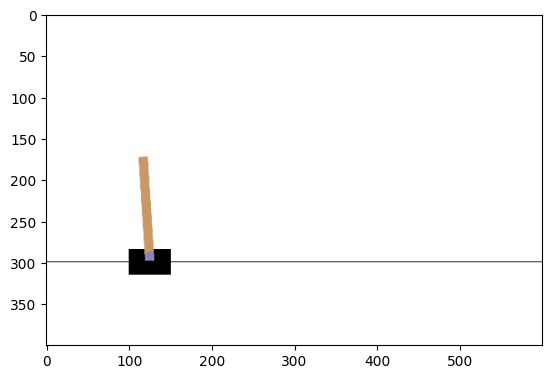

200.0

In [17]:
test(play=True)